# Syllable Extraction

In [1]:
# Import the required libraries
# general libs
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import ast
from collections import Counter
import multidict

# text related
import turkishnlp
from turkishnlp import detector
import string
import re
import wordcloud as wc
from wordcloud import WordCloud
# visualization
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

## Put data in a DataFrame
The data from the three tables are concatenated to for a sigle data frame

In [2]:
# call center df
df = pd.read_csv('transcriptions.csv', index_col=0)

In [3]:
# confirm data types
df.dtypes

Transcription    object
dtype: object

In [4]:
df.head()

,Transcription
0,o zamandan beri ara sıra seyyar satıcılık yapmış
1,öncelikle karşılıklı güven sağlanmalı
2,sırbistan için yeni bir yol ayrımı mı
3,festivale balkanlardan da gelenler oldu
4,grup üyesi birçok kişi tutuklandı


## Extract syllables
Syllables are extacted using the **get_syllables()** function  
That is originally taken from " https://gist.github.com/miratcan/9196ae2591b1f34ab645520a767ced17 " and some parts are editted  
We will create a dictionary of syllables and words from our database

In [5]:
def get_syllables(word):
    syllables = []

    """
    Aşağıdaki satır gelen kelimenin ünlü harfler 1, ünsüzler 0 olacak
    şekilde desenini çıkarır.
    Örneğin: arabacı -> 1010101, türkiye -> 010010
    """
    try: 
        int(word[0:word.index("\'")])
        syllables.append(word[0:word.index("\'")])
        word = word[word.index("\'"):]
    except:pass
    
    word = word.replace("\'","")
    word = word.replace("-", "")
    bits = ''.join(['1' if l in 'aAeEıIiİîoOöÖuUüÜ' else '0' for l in word])

    """
    Aşağıdaki seperators listesi, yakalanacak desenleri ve desen yakalandığında
    kelimenin hangi pozisyondan kesileceğini tanımlıyor.
    Türkçede kelime içinde iki ünlü arasındaki ünsüz, kendinden sonraki
    ünlüyle hece kurar., yani 101 desenini yakaladığımızda kelimeyi
    bulunduğumuz yerden 1 ileri pozisyondan kesmeliyiz. ('101', 1)
    Kelime içinde yan yana gelen iki ünsüzden ilki kendinden önceki ünlüyle,
    ikincisi kendinden sonraki ünlüyle hece kurar. Bu da demek oluyor ki
    1001 desenini yakaladığımızda kelimeyi bulunduğumuz noktadan 2 ileriden
    kesmeliyiz. ('1001', 2),
    Kelime içinde yan yana gelen üç ünsüz harften ilk ikisi kendinden önceki
    ünlüyle, üçüncüsü kendinden sonraki ünlüyle hece kurar. Yani 10001 desenini
    gördüğümüzde kelimeyi bulunduğumuz yerden 3 ileri pozisyondan kesmemiz
    gerek. ('10001', 3)
    """

    seperators = (
        ('101', 1),
        ('1001', 2),
        ('10001', 3),
        ('100001', 4)
    )

    index, cut_start_pos = 0, 0

    # index değerini elimizdeki bitler üzerinde yürütmeye başlıyoruz.
    while index < len(bits):

        """
        Elimizdeki her ayırıcıyı (seperator), bits'in index'inci karakterinden
        itibarent tek tek deneyerek yakalamaya çalışıyoruz.
        """
        if bits[index:].startswith("11"):
            index += 1
            syllables.append(word[cut_start_pos:index])
            cut_start_pos = index

        for seperator_pattern, seperator_cut_pos in seperators:
            
            if bits[index:].startswith(seperator_pattern):

                """
                Yakaladığımızda, en son cut_start posizyonundan, bulunduğumuz
                pozisyonun serpator_cut_pos kadar ilerisine kadar bölümü alıp
                syllables sepetine atıyoruz.
                """
                syllables.append(word[cut_start_pos:index + seperator_cut_pos])

                """
                Index'imiz seperator_cut_pos kadar ilerliyor, ve
                cut_start_pos'u index'le aynı yapıyoruz.
                """

                index += seperator_cut_pos
                cut_start_pos = index
                break

        """
        Index ilerliyor, cut_start_pos'da değişiklik yok.
        """

        index += 1

    # Son kalan heceyi elle sepete atıyoruz.
    syllables.append(word[cut_start_pos:])
    return syllables

In [6]:
print(get_syllables("8'i"))

['8', 'i']


In [7]:
# text from db
df = df.replace(to_replace=r'[,\.\?!;:]', value='', regex=True)
doc = " ".join(df.Transcription.values).lower()

# a dictionary to store the words with their number of appearence
words = Counter(doc.split())

syllables = Counter()
for w in words:
    syllables.update(get_syllables(w))


In [8]:
print(len(syllables))
#for h in syllables:
#    print(h)

1712


## Create syllable dictionary

In [9]:
# Create a data frame for to analyse the syllables
df_syllables = pd.DataFrame()
df_syllables["Syllable"] = syllables.keys()
df_syllables["Occurence"] = syllables.values()

# sort based on the number of occurences of each syllable
df_syllables.sort_values(by=['Occurence'],ascending=False).reset_index(drop=True)

,Syllable,Occurence
0,la,939
1,le,873
2,ya,566
3,ma,557
4,de,532
5,a,520
6,ri,507
7,da,436
8,di,424
9,yo,418


In [10]:
# No of transcriptions available
print(f"Transcriptions: {df.shape[0]}", "(lines)")
print(f"Unique words: {len(words.keys())}")
print(f"Unique syllables {df_syllables.shape[0]}")

Transcriptions: 3686 (lines)
Unique words: 10134
Unique syllables 1712


### Use regular exressions to explore the dataframe

In [11]:
pattern = r're'
df_syllables[df_syllables.Syllable.str.contains(pattern)]

,Syllable,Occurence
94,ret,26
129,rek,63
140,re,260
212,rev,8
252,rey,7
307,rel,1
376,red,4
391,reç,2
416,rep,1
607,tren,1


# Visualization
Word clouds are created to visualize the words and syllables

## Syllable-level Word Cloud

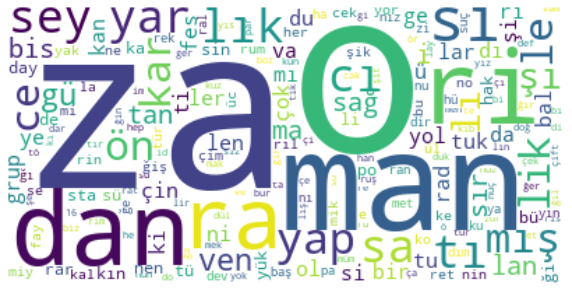

In [12]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

def makeImage(text):
    
    wc = WordCloud(background_color="white")
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.figure(figsize=[10,7])
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


makeImage(getFrequencyDictForText(" ".join(syllables)))

## Word-level word cloud

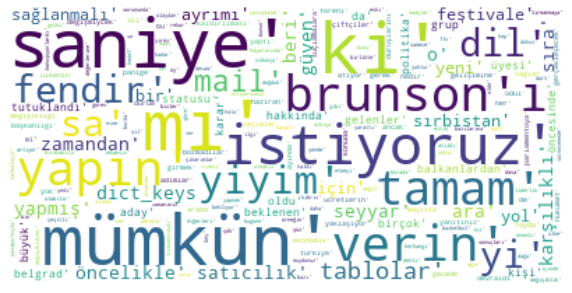

In [13]:
# Create stopword list:
# stopwords = set(STOPWORDS)
# stopwords.update(["drink", "now", "wine", "flavor", "flavors"])
#print(words.keys())
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, background_color="white").generate(str(words.keys()))

# Display the generated image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()